# Spectral Norm Estimation

In [3]:
import numpy as np
import torch
import time
import matplotlib
import matplotlib.pyplot as plt

from torch import nn 
from torch.nn import Parameter
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

# True vs reshaped spectral norm: a toy example

### Utilities

Computation of $\lVert \mathcal{l} \rVert_2$

In [4]:
def l2normalize(v):
    return v / (v.norm())

Initialize a toy convolution layer:

In [5]:
image_size = 64
in_channels = 3
out_channels = 4
kernel_size = 3
stride = 1
padding = 1
dilation = 1

params = (image_size, in_channels, out_channels, kernel_size, stride, padding, dilation)

def init_toy_conv(*params):
    
    conv = torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            stride=stride,
                            padding=padding,
                            dilation=dilation,
                            bias=False)

    transposed_conv = torch.nn.ConvTranspose2d(in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            stride=stride,
                            padding=padding,
                            dilation=dilation,
                            bias=False)


    kernel = torch.randn((out_channels, in_channels, kernel_size, kernel_size))
    conv.weight.data = kernel
    transposed_conv.weight.data = kernel
    
    return kernel, conv, transposed_conv

In [6]:
kernel, conv, transposed_conv = init_toy_conv(params)

### Two ways to calculate true spectral norm: via fft and power iteration 

In [7]:
def calc_spectral_norm_conv(conv, transposed_conv, power_iterations=1):
    """
    Calculates spectral norm of a convolutional layer via power iteration:
    u^T W v = (W v / l2_norm(Wv))^T Wv = l2_norm(Wv) = l2_norm(u)
    """
    u = torch.randn((1, out_channels, image_size, image_size))
    for _ in range(power_iterations):
        v = l2normalize(transposed_conv(u.data))
        conv_res = conv(v)
        u = l2normalize(conv_res)

#     sigma = torch.sum(v * transposed_conv(u.data))
    sigma = torch.norm(conv_res, 2)
    new_kernel = conv.weight.data / (sigma)
    return float(sigma), new_kernel


def calc_spectral_norm_fft(kernel, input_shape=(image_size, image_size)):
    """
    Calculates full spectrum via fft and returns the maximal singular value
    as in https://openreview.net/forum?id=rJevYoA9Fm
    """
    kernel = kernel.transpose(2, 3, 0, 1)
    transform_coefficients = np.fft.fft2(kernel, input_shape, axes=[0, 1])
    sigmas = np.linalg.svd(transform_coefficients, compute_uv=False)
    return np.max(sigmas)

In [8]:
sigma_pi, new_kernel = calc_spectral_norm_conv(conv, transposed_conv, 5)
sigma_pi

9.675148010253906

In [9]:
sigma_fft = calc_spectral_norm_fft(kernel.data.numpy())
sigma_fft

10.346076

### Normalization via reshape

In [10]:
def calc_spectral_norm_reshape(conv, power_iterations=1):
    """
    Calculates spectral norm of a convolutional layer via power iteration on reshaped tensor 
    as in original spectral normalization paper
    """
    w = conv.weight
    height = w.data.shape[0]
    width = w.view(height, -1).data.shape[1]

    u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
    v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
    u.data = l2normalize(u.data)
    v.data = l2normalize(v.data)
    for _ in range(power_iterations):
        v.data = l2normalize(torch.mv(torch.t(w.view(height, -1).data), u.data))
        u.data = l2normalize(torch.mv(w.view(height, -1).data, v.data))

    sigma = u.dot(w.view(height, -1).mv(v))
    new_kernel = kernel / sigma
    
    return float(sigma), new_kernel

In [11]:
sigma_reshape, new_kernel = calc_spectral_norm_reshape(conv, 5)
sigma_reshape

6.107314109802246

# Compare all three methods

In [27]:
matplotlib.rcParams.update({'font.size': 17})

def plot_methods_divergence(power_iterations, title_prefix='', params=params):
    
    image_size, in_channels, out_channels, kernel_size, stride, padding, dilation = params
    
    sigmas_pi = []
    sigmas_fft = []
    sigmas_reshape = []

    for i in range(100):
        kernel, conv, transposed_conv = init_toy_conv(params)

        sigma_pi, new_kernel = calc_spectral_norm_conv(conv, transposed_conv, power_iterations)
        sigmas_pi.append(sigma_pi)

        sigma_fft = calc_spectral_norm_fft(kernel.data.numpy(), input_shape=(image_size, image_size))
        sigmas_fft.append(sigma_fft)

        sigma_reshape, new_kernel = calc_spectral_norm_reshape(conv, power_iterations)
        sigmas_reshape.append(sigma_reshape)

    sigmas_pi = np.array(sigmas_pi)
    sigmas_fft = np.array(sigmas_fft)
    sigmas_reshape = np.array(sigmas_reshape)

    for i, p in enumerate((
        'image_size', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation')):
            print(p, '\t', params[i])
            
    plt.figure(figsize=(15, 7))

    plt.suptitle(f'Divergence of spectral norm with different methods, power iterations={power_iterations}')

    plt.subplot(121)
    plt.title('Method with FFT')
    plt.scatter(sigmas_fft, sigmas_pi)
    plt.xlabel('Spectral norm (with FFT-reshape)')
    plt.ylabel('Spectral norm via convolution')

    plt.subplot(122)
    plt.title('Reshape')
    plt.scatter(sigmas_reshape, sigmas_pi)
    plt.xlabel('Spectral norm via reshape')
    plt.ylabel('Spectral norm via convolution')
    
    plt.subplots_adjust(hspace=1)
    plt.savefig(f'{title_prefix}divergence_{power_iterations}_iters.png')
    plt.show()

As seen from singular values comparison, the power method on 4D tensor fairly accurately approximates the spectral norm even with 3 power iterations, while the power method on reshaped kernel always returns singular values which are two times different. The method with FFT reshape of the kernel and a subsequent SVD works well only with stride = 1, with stride = 2 it gives the wrong singular value, so it is impractical (as the neural networks use different parameters of stride, padding and dilation).

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 2
padding 	 1
dilation 	 1


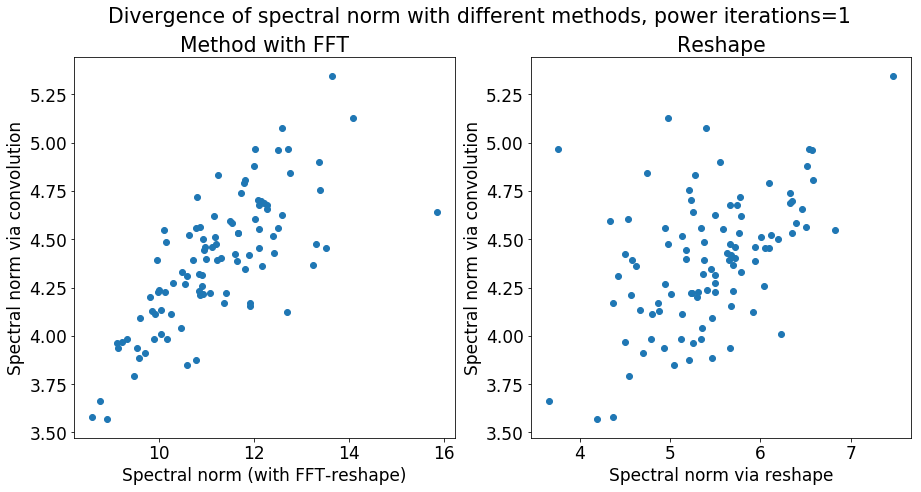

In [28]:
plot_methods_divergence(1)

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 2
padding 	 1
dilation 	 1


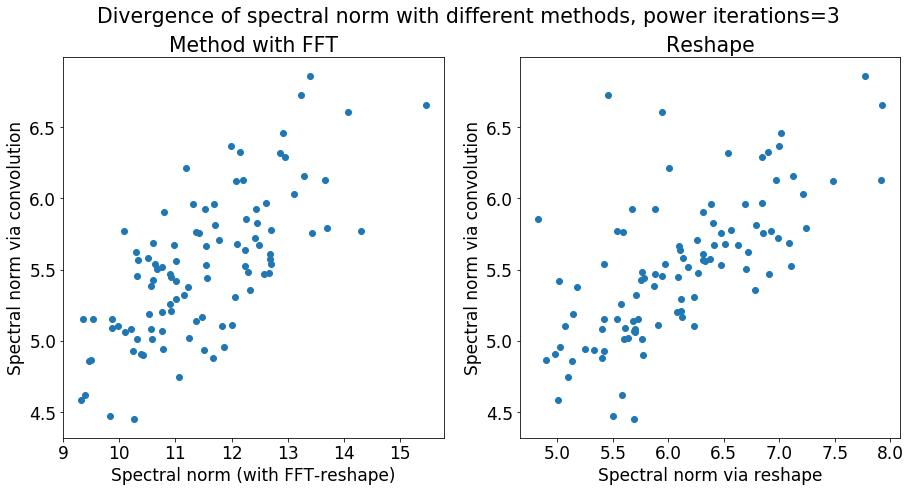

In [29]:
plot_methods_divergence(3)

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 2
padding 	 1
dilation 	 1


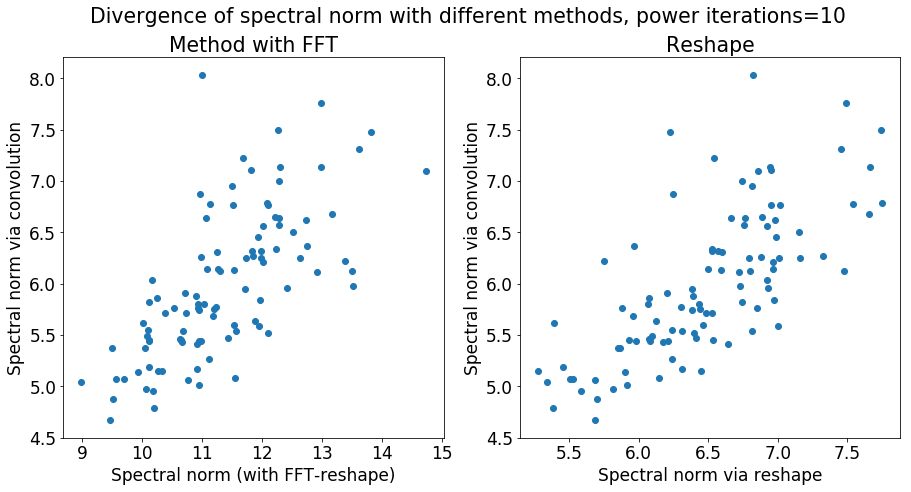

In [30]:
plot_methods_divergence(10)

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 2
padding 	 1
dilation 	 1


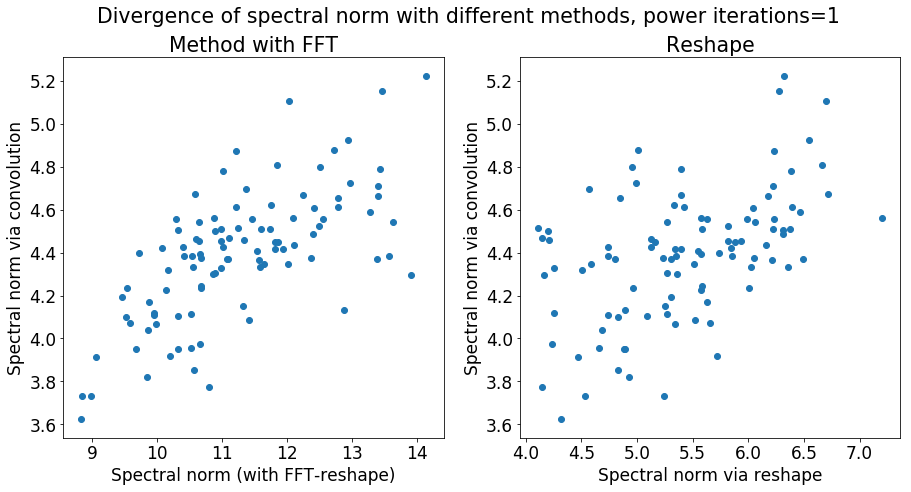

In [31]:
image_size = 64
in_channels = 3
out_channels = 4
kernel_size = 3
stride = 2
padding = 1
dilation = 1

params = (image_size, in_channels, out_channels, kernel_size, stride, padding, dilation)

plot_methods_divergence(1, 'stride_2_', params)

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 2
padding 	 1
dilation 	 1


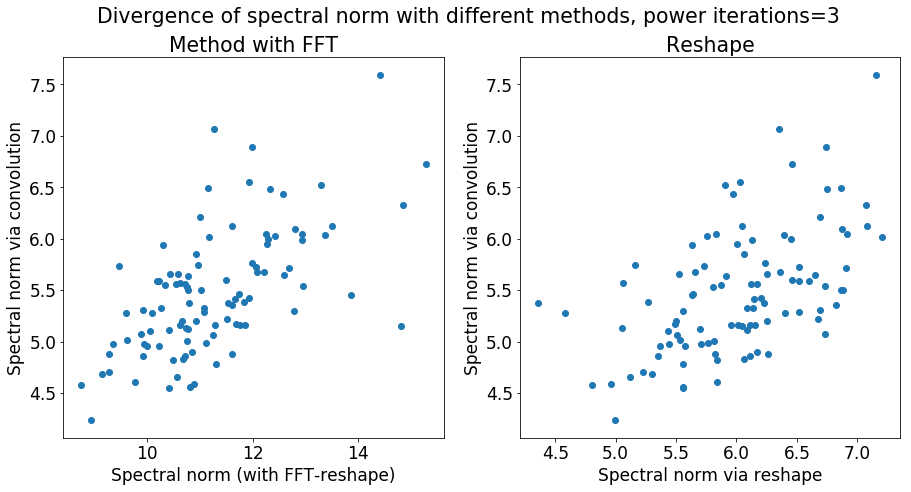

In [32]:
plot_methods_divergence(3, 'stride_2_', params)

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 2
padding 	 1
dilation 	 1


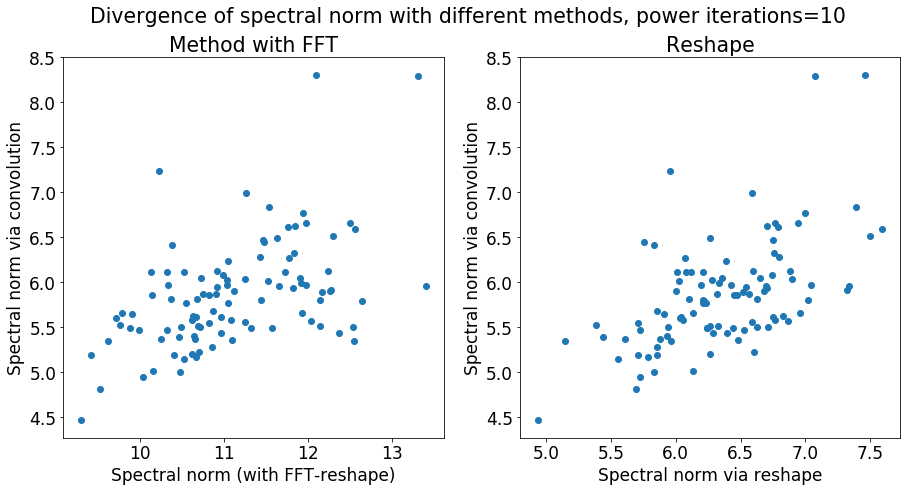

In [33]:
plot_methods_divergence(10, 'stride_2_', params)

# Convergence to the real value 

In [63]:
def plot_convergence_to_sigma(num_pow_iter, params):
    image_size, in_channels, out_channels, kernel_size, stride, padding, dilation = params
    pow_iters = np.arange(1, num_pow_iter + 1)

    for i, p in enumerate((
        'image_size', 'in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation')):
        print(p, '\t', params[i])
            
    plt.figure(figsize=(7, 7))

    plt.title('Convergence')
    plt.xlabel('Num iterations')
    plt.ylabel('Absolute error (sigma_conv - sigma_reshape)')
    
    for i in range(5):
        kernel, conv, transposed_conv = init_toy_conv(params)
        sigmas_pi = []
        sigmas_reshape = []
        for pow_iter in pow_iters:
            sigma_pi, new_kernel = calc_spectral_norm_conv(conv, transposed_conv, power_iterations=pow_iter)
            sigmas_pi.append(sigma_pi)
            
            sigma_reshape, new_kernel = calc_spectral_norm_reshape(conv, power_iterations=pow_iter)
            sigmas_reshape.append(sigma_reshape)
            
        sigmas_pi = np.array(sigmas_pi)
        sigmas_reshape = np.array(sigmas_reshape)
        plt.plot(pow_iters, np.abs(sigmas_reshape - sigmas_pi), label=f'iter_{i}')
        
    plt.legend()
    plt.show()

The power method on 4D tensor and the power method on reshaped kernel has no convergence to each other values. Moreover, they are 3 to 6 times different for a particular choice of parameters.

image_size 	 64
in_channels 	 3
out_channels 	 4
kernel_size 	 3
stride 	 1
padding 	 1
dilation 	 1


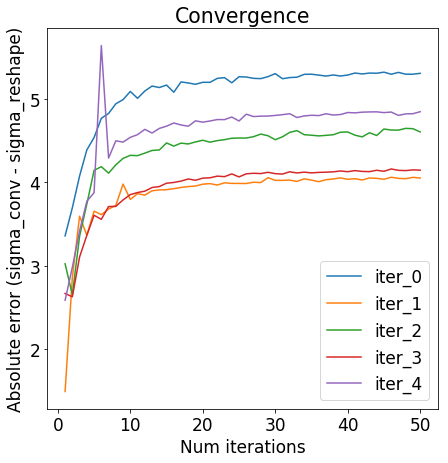

In [65]:
image_size = 64
in_channels = 3
out_channels = 4
kernel_size = 3
stride = 1
padding = 1
dilation = 1

params = (image_size, in_channels, out_channels, kernel_size, stride, padding, dilation)

plot_convergence_to_sigma(50, params)

# Computation time

In [71]:
def plot_computation_time(im_sizes, power_iterations, params=params):
    
    image_size, in_channels, out_channels, kernel_size, stride, padding, dilation = params

    time_pi = []
    time_fft = []
    time_reshape = []

    for im_size in im_sizes:
        kernel, conv, transposed_conv = init_toy_conv(params)

        params = (im_size, in_channels, out_channels, kernel_size, stride, padding, dilation)

        t = time.time()
        sigma_pi, new_kernel = calc_spectral_norm_conv(conv, transposed_conv, power_iterations)
        time_pi.append(time.time() - t)

        t = time.time()
        sigma_fft = calc_spectral_norm_fft(kernel.data.numpy(), input_shape=(image_size, image_size))
        time_fft.append(time.time() - t)

        t = time.time()
        sigma_reshape, new_kernel = calc_spectral_norm_reshape(conv, power_iterations)
        time_reshape.append(time.time() - t)

    
    plt.figure(figsize=(7, 5))
    plt.title(f'Computation time for one image, power iterations = {power_iterations}')
    plt.plot(im_sizes, time_pi, label='tensor power iter')
    plt.plot(im_sizes, time_fft, label='FFT reshape')
    plt.plot(im_sizes, time_reshape, label='reshape power iter')
    plt.xlabel('Image size')
    plt.ylabel('Time (sec)')
    plt.legend()

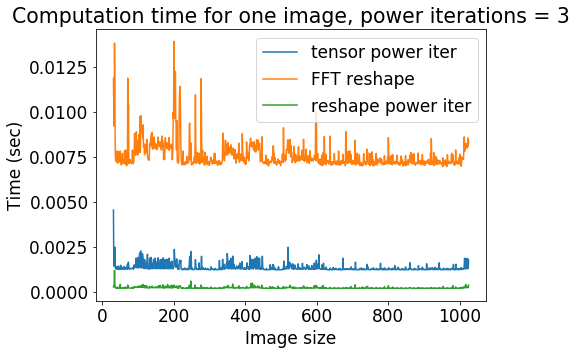

In [73]:
# im_sizes = (32, 64, 128, 256, 512, 1024)
im_sizes = np.arange(32, 1025)
plot_computation_time(im_sizes, power_iterations=3)